In [1]:
#load pandas library to read csv

import pandas as pd
data = pd.read_csv('5k_new.csv')

In [2]:
data.head(10)

,Unnamed: 0,barcode,image,tags_Animal_Prints,tags_Checked_Prints,tags_Embroidered,tags_Flower_Prints,tags_Geometric_Prints,tags_Glitter,tags_Logo_Print,tags_Pattern,tags_Plain,tags_Polka_Dots,tags_Retro_Prints,tags_Stripes,color_Beige,color_Black,color_Blue,color_Brown,color_Gold,color_Green,color_Grey,color_Orange,color_Pink,color_Purple,color_Red,color_Silver,color_White,color_Yellow
0,61486,025753,products%2F025753%2F20210519_170408.JPEG,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,61487,011668,products%2F011668%2F20200909_145141.jpg,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,61489,012412,products%2F012412%2F20200928_162333.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,61498,029327,products%2F029327%2F20210630_111603_1625052485...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,61509,026337,products%2F026337%2F20210601_154238.JPEG,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,61518,017615,products%2F017615%2F20201229_175104.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,61519,034480,products%2F034480%2F20210906_162831_1631001755...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,61522,006435,products%2F006435%2F20200717_152050.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,61527,2005747,products%2F2005747%2Fimage_1632862846390.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,61531,2005461,products%2F2005461%2F1625664803087168967847902...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [3]:
#replace % signs with _ for image paths

data.loc[:,('image')] = data.loc[:,('image')].str.replace('%','_')

In [4]:
##remove corrupt images which cannot be loaded

data.loc[data['image']=='products_2F034728_2F20210824_105642_1629797764292.jpg']
data.loc[data['image']=='products_2F009093_2F20200825_160812.jpg']
data.loc[data['image']=='products_2F2007508_2F20210311_101641.jpg']
data.loc[data['image']=='products_2F005467_2F20200609_143233.jpg']
data.loc[data['image']=='products_2F004974_2F20200508_125424.jpg']
data.loc[data['image']=='products_2F025376_2F20210504_112116.jpg']

,Unnamed: 0,barcode,image,tags_Animal_Prints,tags_Checked_Prints,tags_Embroidered,tags_Flower_Prints,tags_Geometric_Prints,tags_Glitter,tags_Logo_Print,tags_Pattern,tags_Plain,tags_Polka_Dots,tags_Retro_Prints,tags_Stripes,color_Beige,color_Black,color_Blue,color_Brown,color_Gold,color_Green,color_Grey,color_Orange,color_Pink,color_Purple,color_Red,color_Silver,color_White,color_Yellow
4350,98702,025376,products_2F025376_2F20210504_112116.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
data.drop([3921,2926,2872,82,3362,4350],inplace=True)

In [6]:
data.tail()

,Unnamed: 0,barcode,image,tags_Animal_Prints,tags_Checked_Prints,tags_Embroidered,tags_Flower_Prints,tags_Geometric_Prints,tags_Glitter,tags_Logo_Print,tags_Pattern,tags_Plain,tags_Polka_Dots,tags_Retro_Prints,tags_Stripes,color_Beige,color_Black,color_Blue,color_Brown,color_Gold,color_Green,color_Grey,color_Orange,color_Pink,color_Purple,color_Red,color_Silver,color_White,color_Yellow
4995,106668,022075,products_2F022075_2F20210309_162730.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4996,106675,029835,products_2F029835_2F20210706_125858_1625571894...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4997,106685,a011885,20200914_175940.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4998,106696,034163,products_2F034163_2F20210831_141257_1630418870...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4999,106710,010299,products_2F010299_2F20201001_102715.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
#make a new column for tags marked as 1 to be in one place

data['tags']='' # to create an empty column

for col_name in data.columns:
    data.loc[data[col_name]==1,'tags']= data['tags']+' '+col_name

In [8]:
#new csv which conatins image paths and their tags only

cleaned_data = data[['image','tags']]

In [9]:
cleaned_data.head()

,image,tags
0,products_2F025753_2F20210519_170408.JPEG,tags_Embroidered color_Beige
1,products_2F011668_2F20200909_145141.jpg,tags_Plain color_Beige
2,products_2F012412_2F20200928_162333.jpg,tags_Stripes color_Blue color_White
3,products_2F029327_2F20210630_111603_1625052485...,tags_Pattern color_Black
4,products_2F026337_2F20210601_154238.JPEG,tags_Pattern tags_Plain color_Orange


In [10]:
from google.colab import drive  
drive._mount('/content/drive') 

Mounted at /content/drive


In [11]:
#copy images zip file into content folder

!cp -avr /content/drive/MyDrive/5k-20211208T135002Z-001.zip /content

'/content/drive/MyDrive/5k-20211208T135002Z-001.zip' -> '/content/5k-20211208T135002Z-001.zip'


In [ ]:
!unzip /content/5k-20211208T135002Z-001.zip

Fastai

In [ ]:
#install fastai library for deep learning

!pip install fastai==2.5

In [14]:
!pip install timm==0.4.5

     |████████████████████████████████| 287 kB 14.6 MB/s 


In [15]:
#import all classes and functions 

from fastai.vision.all import *

In [16]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

In [15]:
batch_tfms = aug_transforms( max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [21]:
'''function which loads images from csv and their appropiate tag seperated by ' ' delimeter into batch with 
   some augmentations applied such as change lightining

'''

def get_dls(bs, size):
    dblock =  DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'/content/5k/'),  #adding prefix to make correct path of the image
                   splitter=RandomSplitter(),  #split train data into valid randomly
                   get_y=ColReader(1, label_delim=' '), ## tags column contains our labels seperated by ' ' 
                   item_tfms = Resize(size),     #Resize images
                   batch_tfms = [*aug_transforms(size=size, min_scale=0.75,max_warp=0,max_lighting=0.1),
                               Normalize.from_stats(*imagenet_stats),Contrast(max_lighting=0.3)])
    return dblock.dataloaders(cleaned_data, bs=bs)

In [22]:
# batches and loads data into proper format with images resized to 460

dls = get_dls(32,460)

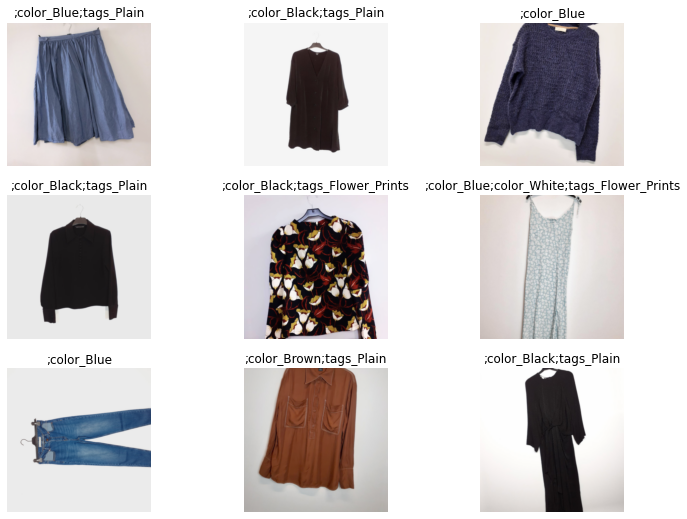

In [23]:
dls.show_batch(max_n=9, figsize=(12,9))

In [24]:
from fastai.metrics import accuracy_multi  ##metric for multi label classificatio

In [19]:
learn = cnn_learner(dls, resnet50,loss_func=BCEWithLogitsLossFlat() ,metrics=[accuracy_multi]) ## builds a learner containing resnet 50 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
learn = Learner(dls,new_model,loss_func=BCEWithLogitsLossFlat() ,metrics=[accuracy_multi])

In [ ]:
learn = cnn_learner(dls)

In [20]:
learn.to_fp16()

In [21]:
learn.freeze()
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 230 x 230 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 115 x 11 
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

SuggestedLRs(valley=0.0008317637839354575)

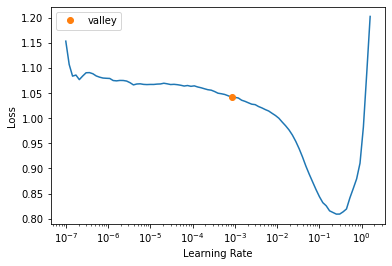

In [22]:
learn.lr_find()

In [23]:
lr = 7e-3
# learn = learn.to_fp16()

In [24]:
learn.fit_one_cycle(8, slice(lr)) ## Training out model for 8 epochs

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.578437,0.175564,0.948156,05:16
1,0.194407,0.133207,0.951867,05:15
2,0.140379,0.121309,0.956246,05:14
3,0.120839,0.113367,0.959437,05:14
4,0.110548,0.109760,0.959883,05:15
5,0.097884,0.105155,0.961515,05:15
6,0.088087,0.103705,0.962110,05:15
7,0.080647,0.104295,0.961516,05:15


SuggestedLRs(valley=7.585775892948732e-05)

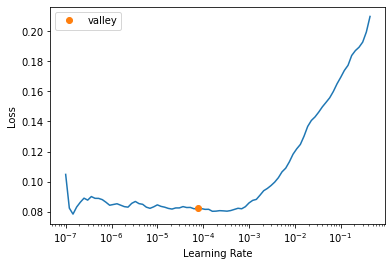

In [25]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.130986,0.271947,0.947747,06:52
1,0.130566,0.140554,0.944816,06:51
2,0.117908,0.112476,0.959326,06:52
3,0.104382,0.100009,0.962332,06:52
4,0.088892,0.098065,0.963408,06:47


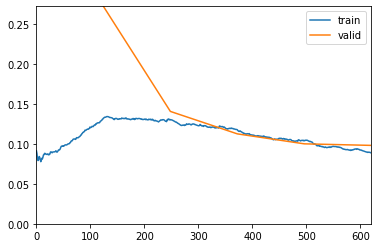

Epoch 4: reducing lr to 1.9269978501117515e-09


In [26]:
learn.fit_one_cycle(5,9e-4,cbs=[ShowGraphCallback(),ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=3),EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=10),SaveModelCallback(monitor='accuracy_multi',every_epoch=2),CSVLogger])

In [29]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [30]:
learn.dls = get_dls(16,600)

SuggestedLRs(valley=0.004365158267319202)

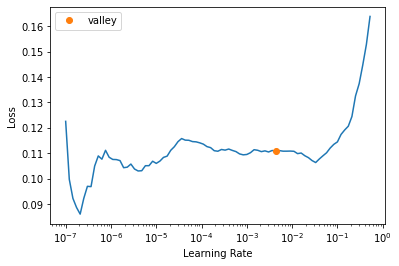

In [31]:
learn.freeze()
learn.lr_find()

In [32]:
learn.fit_one_cycle(7, slice(5e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.137055,1.296066,0.941142,04:42
1,0.210055,1.159241,0.942478,04:40
2,0.195432,0.776713,0.921547,04:41
3,0.162187,6.297659,0.937059,04:40
4,0.124632,1.433180,0.954502,04:41
5,0.110669,1.173910,0.957062,04:41
6,0.102183,2.066556,0.954056,04:39


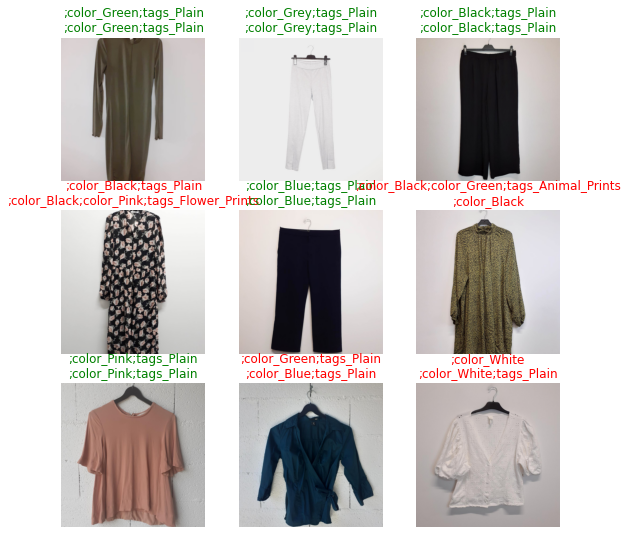

In [27]:
learn.show_results()

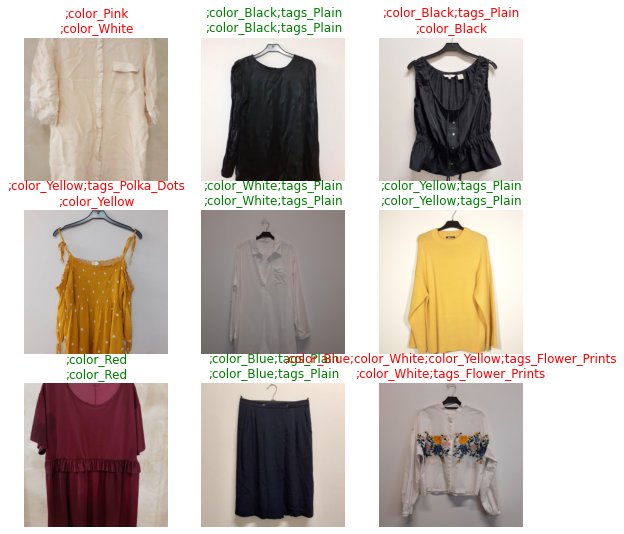

In [28]:
learn.show_results()

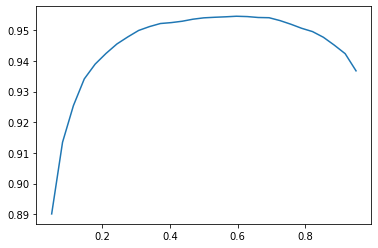

In [35]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [29]:
learn.export('/content/drive/MyDrive/export1.pkl')

In [41]:
learn.predict('/content/5k/003690.jpg')

((#2) ['','color_Black'],
 tensor([ True, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
 tensor([9.9974e-01, 3.1499e-02, 7.3848e-01, 2.3825e-02, 1.5484e-02, 2.6939e-03,
         3.3908e-02, 1.3285e-01, 5.2201e-03, 2.4470e-02, 5.4906e-03, 2.4061e-03,
         6.5127e-04, 4.0510e-01, 9.3400e-03, 7.5448e-02, 1.2336e-02, 6.0976e-03,
         2.6190e-01, 3.0734e-02, 3.0754e-03, 2.9828e-04, 2.0307e-01, 1.6277e-02,
         1.0091e-02, 3.9048e-02, 1.3121e-02]))

##INFERENCE

In [18]:
##Import necessary libraires for inference


from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

import torch
from torch import nn


In [32]:
##load model from path

new_model = load_learner('/content/drive/MyDrive/export.pkl')

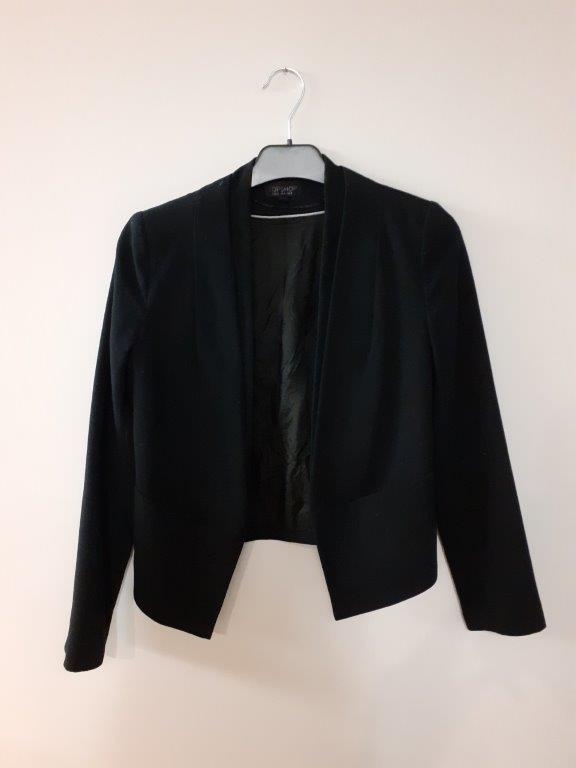

(#2) ['color_Black','tags_Plain']

In [41]:
## Inference code if you are in google collab 

from google.colab.patches import cv2_imshow
import cv2

image = cv2.imread('/content/5k/000009.jpg')
cv2_imshow(image)        ## Use cv2.imshow('window',image) --> if in local env
image = cv2.resize(image,(460,460))

new_model.predict(image)[0][1:]